# ARIMA model

In [2]:
def __print(message):
    # print(message)
    pass

def jb_and_dw_test(actual, predict):
    from statsmodels.stats.stattools import jarque_bera, durbin_watson
    from sklearn.metrics import mean_squared_error
    import numpy as np
    import math as math
    

    __print(f"{'-'*10} jb_and_dw_test {'-'*10}")

    # print(predict.head)
    res = actual - predict
    # print(res)
    mse = mean_squared_error(actual, predict)
    rmse = math.sqrt(mse)
    mean = sum(res) / len(res)
    __print(f'mse: {mse} rmse: {rmse} mean: {mean}')

    mape = np.mean(np.abs((actual - predict) / actual))   # mean absolute percentage error

    score, jb_pvalue, _, _ = jarque_bera(res)

    if jb_pvalue < 0.05:
        __print(f'JB test. residuals are NOT be normally distributed. {jb_pvalue}')
    else:
        __print(f'JB test. residuals seem normally distributed. {jb_pvalue}')

    dw_res = durbin_watson(res)
    if 1.5 <= dw_res <= 2.5:
        __print(f'DW test. no evidence of autocorrelation in residuals. {dw_res}')
    else:
        __print(f'DW test. evidence of autocorrelation in residuals. {dw_res}')

    return res, jb_pvalue, dw_res, mse, rmse, mean, mape

In [3]:
def plot_it(train=None, predict=None, actual=None, column='TBA'):
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set()
    fig = plt.figure(figsize=(10,4))
    # fig.suptitle(f'column: {column}')

    plt.clf()
    plt.title(column, fontsize=12)
    plt.plot(train)
    plt.plot(predict)
    plt.plot(actual)
    plt.legend(('train', 'predict', 'actual'), fontsize=10)
    return plt

# ARIMA to fit model

---------- ARIMA order: (0, 1, 0) ----------
                               SARIMAX Results                                
Dep. Variable:             CS-Aaa-3MO   No. Observations:                  127
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  -2.795
Date:                Fri, 09 Oct 2020   AIC                              9.589
Time:                        20:16:58   BIC                             15.262
Sample:                    01-31-2009   HQIC                            11.894
                         - 07-31-2019                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Market-RMRF-diff     0.0028      0.002      1.295      0.195      -0.001       0.007
sigma2               0.0612      0.003     17.846      0.000       0

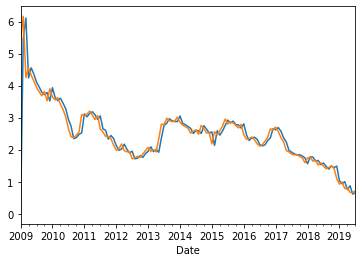

In [4]:

import nb_credit_spread as cslibrary
from statsmodels.tsa.arima.model import ARIMA

cslib = cslibrary.creditspread()
start_date = '2009-01-31' #'1990-01-31' # '2009-01-31'

ytw = cslib.get_ytw_from_date_delta(start=start_date)

column = 'CS-Aaa-3MO'
endog, exog = ytw[column], ytw["Market-RMRF-diff"]

o = (0, 1, 0)
print(f"{'-'*10} ARIMA order: {o} {'-'*10}")
model = ARIMA(endog=endog, exog=exog, order=o) #, trend='c')
model_fit = model.fit()
print(model_fit.summary())
print(f"model fit bic: {model_fit.bic}")
model_fit.predict().plot()
endog.plot()
print(model_fit.resid)

# ARIMA fit model. Train 80%. CS endog. None exog

({'series': 'CS-Aaa-3MO',
  'order': (2, 1, 0),
  'trend': None,
  'aic': -2.6131019459725096,
  'bic': 8.732025681833402,
  'hqic': 1.9960678497701725,
  'jb': 0.24279181370359404,
  'dw': 1.8193601986759167,
  'mse': 0.015740294009640946,
  'rmse': 0.1254603284295117,
  'mean': -0.040126350529446644,
  'mape': 0.0830055351617413,
  'pvalue': 0.40811327621378235},
 <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x11bc76a90>)

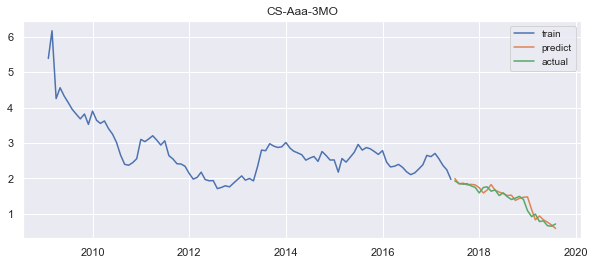

In [5]:
import logging
name, level = "run_model", logging.INFO
logger = logging.getLogger(name)
fhandler = logging.FileHandler(filename=f'logs/{name}-{logging.getLevelName(level)}.log') #, mode='a')
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# fhandler.setFormatter(formatter)
logger.setLevel(level)
logger.addHandler(fhandler)

def log(message):
    logger.info(message)

def run_model(col, endog, exog, order, trend=None):
    import nb_credit_spread as cslibrary
    from statsmodels.tsa.arima.model import ARIMA

    model_fit = ARIMA(endog=endog, exog=exog, order=order, trend=trend).fit()
    # print(model_fit.summary())
    log(model_fit.summary())
    # print(f"model fit aic {model_fit.aic} bic: {model_fit.bic} hqic: {model_fit.hqic}")
    model_fit.predict().plot()
    endog.plot()
    # print(model_fit.resid)

    length = int(len(endog) * 0.8)

    train, actual = endog[0:length], endog[length:len(endog)] # set training as 80% data. set 20% to actual
    # exog = exog[0:length]
    exog = exog

    pre_start, pre_end = '2017-06-30', '2019-07-31'
    # print(f'train: {train.shape} actual: {actual.shape} exog: {exog.shape if exog != None else exog}')

    predict = model_fit.predict(start=pre_start, end=pre_end, exog=exog)

    res, jb_pvalue, dw_res, mse, rmse, mean, mape = jb_and_dw_test(actual, predict)
    # print(f"aic: {model_fit.aic} bic: {model_fit.bic} hqic: {model_fit.hqic} jb: {jb_pvalue} dw: {dw_res} mse: {mse} rmse: {rmse} mean: {mean} mape: {mape}")
    
    # print(f"{'*'*10} ARIMA order: {order} cs: {col} results (aic, bic, hqic, jb, dw, mse, rmse, mean, mape) {'*'*10}")
    # print(f"{model_fit.aic} {model_fit.bic} {model_fit.hqic} {jb_pvalue} {dw_res} {mse} {rmse} {mean} {mape}")

    r = {"series": col, "order": order, "trend": trend, "aic": model_fit.aic, "bic": model_fit.bic, "hqic": model_fit.hqic, "jb": jb_pvalue, "dw": dw_res, "mse": mse, "rmse": rmse, "mean": mean, "mape": mape, "pvalue": model_fit.pvalues[0]}

    plot_it(train, predict, actual, col)
    # print(res.describe())
    return r, model_fit

exog = ytw[ ['Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff'] ]
exog = ytw[ ['TB-3MO-TY-diff', 'TB-1YR-TY-diff', 'TB-5YR-TY-diff']]
exog = ytw[ ['Market-RMRF-diff']]
run_model(col='CS-Aaa-3MO', endog=ytw['CS-Aaa-3MO'], exog=exog, order=(2, 1, 0)) # Aaa - good

In [5]:
log("test 2")

In [ ]:

import nb_credit_spread as cslibrary
cslib = cslibrary.creditspread()
start_date = '2009-01-31' #'1990-01-31' # '2009-01-31'
ytw = cslib.get_ytw_from_date_delta(start=start_date)
# TB-3MO-TY-diff	TB-1YR-TY-diff	TB-5YR-TY-diff
# Market-RMRF-diff	Market-SP500-diff
# Econ-UNRATE-diff	Econ-DSPIC96-diff	Econ-CPIAUCSL-diff	Econ-CPILFESL-diff	Econ-INDPRO-diff	Econ-PCE-diff

# JB > 0.05 - residuals normally distributed
# DW between 1.5 and 2.5 - no evidence of autocorrelation in residuals
import logging
import test_cs_data_analysis as analysis

def log_results(r, fit):
    log.info(f"result:\n{r}\ncoef:\n{fit.arparams}\nstderr:\n{fit.bse}\npvalues:\n{fit.pvalues}")

def setLogger(name, level):
    import logging
    log = logging.getLogger(name)
    fhandler = logging.FileHandler(filename=f'logs/{name}-{logging.getLevelName(level)}.log') #, mode='a')
    log.setLevel(level)
    log.addHandler(fhandler)
    return log

def clearlogger(log):
    try:
        # logger = logging.getLogger()
        while log.hasHandlers():
            log.removeHandler(logger.handlers[0])

        if (log.hasHandlers()):
            log.handlers.clear()
    except:
        pass

## Base Model AR(p) and MA(q) based on PACF and ACF

/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn(&quot;Maximum Likelihood optimization failed to converge. &quot;
/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn(&quot;Maximum Likelihood optimization failed to converge. &quot;
/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn(&quot;Maximum Likelihood optimization failed to converge. &quot;
/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567

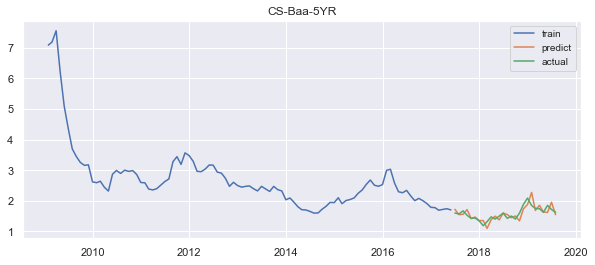

In [6]:
''' Base Model '''
import pandas as pd
t = pd.DataFrame(columns=['series', 'order', 'trend', 'aic', 'bic', 'hqic', 'jb', 'dw', 'mse', 'rmse', 'mean', 'mape'])

t = t.append( run_model(col=f"CS-Aaa-3MO", endog=ytw["CS-Aaa-3MO"], exog=None, order=(3,1,3))[0], ignore_index=True ) # Aaa - good

t = t.append( run_model(col=f"CS-Aaa-1YR", endog=ytw["CS-Aaa-1YR"], exog=None, order=(4,1,3))[0], ignore_index=True ) 
t = t.append( run_model(col=f"CS-Aaa-5YR", endog=ytw["CS-Aaa-5YR"], exog=None, order=(1,1,1))[0], ignore_index=True ) 

t = t.append( run_model(col="CS-Aa-3MO", endog=ytw["CS-Aa-3MO"], exog=None, order=(3,1,3))[0], ignore_index=True ) # Aa - good
t = t.append( run_model(col="CS-Aa-1YR", endog=ytw["CS-Aa-1YR"], exog=None, order=(4,1,3))[0], ignore_index=True ) # Aa - good
t = t.append( run_model(col="CS-Aa-5YR", endog=ytw["CS-Aa-5YR"], exog=None, order=(1,1,1))[0], ignore_index=True ) # Aa - good

t = t.append( run_model(col="CS-A-3MO", endog=ytw["CS-A-3MO"], exog=None, order=(3,1,3))[0], ignore_index=True ) # A - good
t = t.append( run_model(col="CS-A-1YR", endog=ytw["CS-A-1YR"], exog=None, order=(1,1,1))[0], ignore_index=True ) # A - good
t = t.append( run_model(col="CS-A-5YR", endog=ytw["CS-A-5YR"], exog=None, order=(3,1,3))[0], ignore_index=True ) # A - good

t = t.append( run_model(col="CS-Baa-3MO", endog=ytw["CS-Baa-3MO"], exog=None, order=(3,1,3))[0], ignore_index=True ) # Baa - good
t = t.append( run_model(col="CS-Baa-1YR", endog=ytw["CS-Baa-1YR"], exog=None, order=(1,1,1))[0], ignore_index=True ) 
t = t.append( run_model(col="CS-Baa-5YR", endog=ytw["CS-Baa-5YR"], exog=None, order=(3,1,3))[0], ignore_index=True ) 
log(t)
print(t)

## Base Model determined by best BIC

        series      order trend         aic         bic        hqic        jb  \
0   CS-Aaa-3MO  (2, 1, 0)  None   -3.927268    4.581578   -0.470390  0.447518   
1   CS-Aaa-1YR  (2, 1, 0)  None  -30.771436  -22.262591  -27.314559  0.939684   
2   CS-Aaa-5YR  (2, 1, 1)  None  -66.435240  -55.090113  -61.826071  0.523101   
3    CS-Aa-3MO  (2, 1, 2)  None  -84.609547  -70.428138  -78.848085  0.580107   
4    CS-Aa-1YR  (1, 1, 0)  None -112.600237 -106.927673 -110.295652  0.591280   
5    CS-Aa-5YR  (1, 1, 0)  None  -74.931298  -69.258735  -72.626713  0.511891   
6     CS-A-3MO  (1, 1, 0)  None  -58.282366  -52.609802  -55.977781  0.755013   
7     CS-A-1YR  (1, 1, 0)  None  -95.723233  -90.050669  -93.418648  0.693213   
8     CS-A-5YR  (1, 1, 1)  None  -50.440893  -41.932048  -46.984016  0.788466   
9   CS-Baa-3MO  (4, 1, 0)  None  -44.022882  -29.841472  -38.261420  0.715688   
10  CS-Baa-1YR  (4, 1, 0)  None  -59.812916  -45.631506  -54.051453  0.518179   
11  CS-Baa-5YR  (4, 1, 0)  N

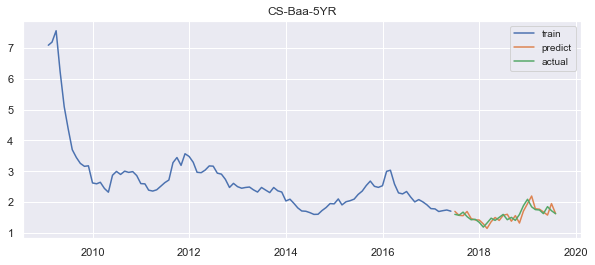

In [7]:
''' Base Model '''
import pandas as pd
t = pd.DataFrame(columns=['series', 'order', 'trend', 'aic', 'bic', 'hqic', 'jb', 'dw', 'mse', 'rmse', 'mean', 'mape'])

t = t.append( run_model(col=f"CS-Aaa-3MO", endog=ytw["CS-Aaa-3MO"], exog=None, order=(2,1,0))[0], ignore_index=True ) # Aaa - good
t = t.append( run_model(col=f"CS-Aaa-1YR", endog=ytw["CS-Aaa-1YR"], exog=None, order=(2,1,0))[0], ignore_index=True ) 
t = t.append( run_model(col=f"CS-Aaa-5YR", endog=ytw["CS-Aaa-5YR"], exog=None, order=(2,1,1))[0], ignore_index=True ) 

t = t.append( run_model(col="CS-Aa-3MO", endog=ytw["CS-Aa-3MO"], exog=None, order=(2,1,2))[0], ignore_index=True ) # Aa - good
t = t.append( run_model(col="CS-Aa-1YR", endog=ytw["CS-Aa-1YR"], exog=None, order=(1,1,0))[0], ignore_index=True ) # Aa - good
t = t.append( run_model(col="CS-Aa-5YR", endog=ytw["CS-Aa-5YR"], exog=None, order=(1,1,0))[0], ignore_index=True ) # Aa - good

t = t.append( run_model(col="CS-A-3MO", endog=ytw["CS-A-3MO"], exog=None, order=(1,1,0))[0], ignore_index=True ) # A - good
t = t.append( run_model(col="CS-A-1YR", endog=ytw["CS-A-1YR"], exog=None, order=(1,1,0))[0], ignore_index=True ) # A - good
t = t.append( run_model(col="CS-A-5YR", endog=ytw["CS-A-5YR"], exog=None, order=(1,1,1))[0], ignore_index=True ) # A - good

t = t.append( run_model(col="CS-Baa-3MO", endog=ytw["CS-Baa-3MO"], exog=None, order=(4,1,0))[0], ignore_index=True ) # Baa - good
t = t.append( run_model(col="CS-Baa-1YR", endog=ytw["CS-Baa-1YR"], exog=None, order=(4,1,0))[0], ignore_index=True ) 
t = t.append( run_model(col="CS-Baa-5YR", endog=ytw["CS-Baa-5YR"], exog=None, order=(4,1,0))[0], ignore_index=True ) 

print(t)

/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn(&quot;Maximum Likelihood optimization failed to converge. &quot;
/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn(&quot;Maximum Likelihood optimization failed to converge. &quot;
        series      order trend         aic         bic        hqic        jb  \
0   CS-Aaa-3MO  (2, 1, 0)  None   -2.613102    8.732026    1.996068  0.242792   
1   CS-Aaa-1YR  (2, 1, 0)  None  -29.926146  -18.581019  -25.316977  0.827839   
2   CS-Aaa-5YR  (2, 1, 1)  None  -84.482998  -70.301588  -78.721535  0.346603   
3    CS-Aa-3MO  (2, 1, 2)  None  -83.106332  -66.088640  -76.192577  0.328305   
4    CS-Aa-1Y

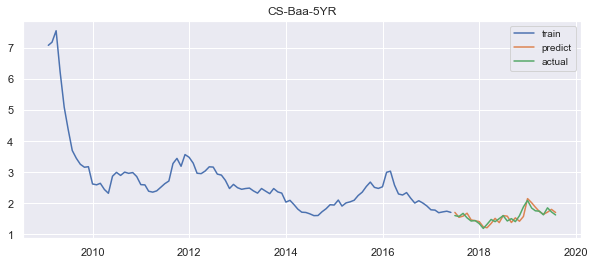

In [8]:
''' Base Model + exog Market '''
import pandas as pd
t = pd.DataFrame(columns=['series', 'order', 'trend', 'aic', 'bic', 'hqic', 'jb', 'dw', 'mse', 'rmse', 'mean', 'mape', 'pvalue'])
exog = ytw[[ 'Market-RMRF-diff' ]]

t = t.append( run_model(col=f"CS-Aaa-3MO", endog=ytw["CS-Aaa-3MO"], exog=exog, order=(2,1,0))[0], ignore_index=True ) # Aaa - good
t = t.append( run_model(col=f"CS-Aaa-1YR", endog=ytw["CS-Aaa-1YR"], exog=exog, order=(2,1,0))[0], ignore_index=True ) 
t = t.append( run_model(col=f"CS-Aaa-5YR", endog=ytw["CS-Aaa-5YR"], exog=exog, order=(2,1,1))[0], ignore_index=True )

t = t.append( run_model(col="CS-Aa-3MO", endog=ytw["CS-Aa-3MO"], exog=exog, order=(2,1,2))[0], ignore_index=True ) # Aa - good
t = t.append( run_model(col="CS-Aa-1YR", endog=ytw["CS-Aa-1YR"], exog=exog, order=(1,1,0))[0], ignore_index=True ) # Aa - good
t = t.append( run_model(col="CS-Aa-5YR", endog=ytw["CS-Aa-5YR"], exog=exog, order=(1,1,0))[0], ignore_index=True ) # Aa - good

t = t.append( run_model(col="CS-A-3MO", endog=ytw["CS-A-3MO"], exog=exog, order=(1,1,0))[0], ignore_index=True ) # A - good
t = t.append( run_model(col="CS-A-1YR", endog=ytw["CS-A-1YR"], exog=exog, order=(1,1,0))[0], ignore_index=True ) # A - good
t = t.append( run_model(col="CS-A-5YR", endog=ytw["CS-A-5YR"], exog=exog, order=(1,1,1))[0], ignore_index=True ) # A - good

t = t.append( run_model(col="CS-Baa-3MO", endog=ytw["CS-Baa-3MO"], exog=exog, order=(4,1,0))[0], ignore_index=True ) # Baa - good
t = t.append( run_model(col="CS-Baa-1YR", endog=ytw["CS-Baa-1YR"], exog=exog, order=(4,1,0))[0], ignore_index=True ) 
t = t.append( run_model(col="CS-Baa-5YR", endog=ytw["CS-Baa-5YR"], exog=exog, order=(4,1,0))[0], ignore_index=True ) 

print(t)

/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/Justin/Desktop/git-hub-justin-grigg/testPythonDissAnalysis/env/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


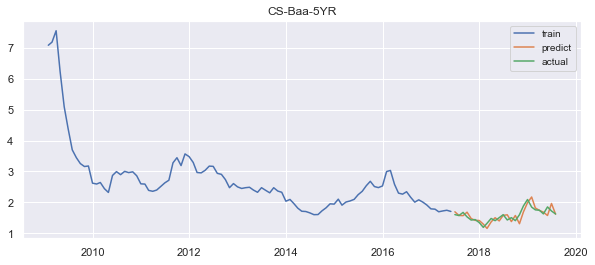

In [9]:
''' Base Model + exog Market ''' 
''' Econ-UNRATE-diff	Econ-DSPIC96-diff	Econ-CPIAUCSL-diff	Econ-CPILFESL-diff	Econ-INDPRO-diff	Econ-PCE-diff '''
import pandas as pd
t = pd.DataFrame(columns=['series', 'order', 'trend', 'aic', 'bic', 'hqic', 'jb', 'dw', 'mse', 'rmse', 'mean', 'mape', 'pvalue'])
exog = ytw[[ 'Econ-PCE-diff' ]]

t = t.append( run_model(col=f"CS-Aaa-3MO", endog=ytw["CS-Aaa-3MO"], exog=exog, order=(2,1,0))[0], ignore_index=True ) # Aaa - good
t = t.append( run_model(col=f"CS-Aaa-1YR", endog=ytw["CS-Aaa-1YR"], exog=exog, order=(2,1,0))[0], ignore_index=True ) 
t = t.append( run_model(col=f"CS-Aaa-5YR", endog=ytw["CS-Aaa-5YR"], exog=exog, order=(2,1,1))[0], ignore_index=True )

t = t.append( run_model(col="CS-Aa-3MO", endog=ytw["CS-Aa-3MO"], exog=exog, order=(2,1,2))[0], ignore_index=True ) # Aa - good
t = t.append( run_model(col="CS-Aa-1YR", endog=ytw["CS-Aa-1YR"], exog=exog, order=(1,1,0))[0], ignore_index=True ) # Aa - good
t = t.append( run_model(col="CS-Aa-5YR", endog=ytw["CS-Aa-5YR"], exog=exog, order=(1,1,0))[0], ignore_index=True ) # Aa - good

t = t.append( run_model(col="CS-A-3MO", endog=ytw["CS-A-3MO"], exog=exog, order=(1,1,0))[0], ignore_index=True ) # A - good
t = t.append( run_model(col="CS-A-1YR", endog=ytw["CS-A-1YR"], exog=exog, order=(1,1,0))[0], ignore_index=True ) # A - good
t = t.append( run_model(col="CS-A-5YR", endog=ytw["CS-A-5YR"], exog=exog, order=(1,1,1))[0], ignore_index=True ) # A - good

t = t.append( run_model(col="CS-Baa-3MO", endog=ytw["CS-Baa-3MO"], exog=exog, order=(4,1,0))[0], ignore_index=True ) # Baa - good
t = t.append( run_model(col="CS-Baa-1YR", endog=ytw["CS-Baa-1YR"], exog=exog, order=(4,1,0))[0], ignore_index=True ) 
t = t.append( run_model(col="CS-Baa-5YR", endog=ytw["CS-Baa-5YR"], exog=exog, order=(4,1,0))[0], ignore_index=True ) 

# print(t)

In [ ]:
''' Aaa '''
cs = 'CS-Aaa-3MO'
#log = analysis.setlogfile(f"test.{cs}.ARIMA", logging.INFO)
#log.info(f"{cs}")
run_model(col='CS-Aaa-3MO', endog=ytw['CS-Aaa-3MO'], exog=None, order=(2,1,0)) # Aaa - good
#r, fit = run_model(col=cs, endog=ytw[cs], exog=None, order=(1,1,3))
#log_results(r, fit)

# print(f"result:\n{r}\ncoef:\n{fit.arparams}\nstderr: {fit.bse}\npvalues:\n{fit.pvalues}")

# run_model(col='CS-Aaa-3MO', endog=ytw['CS-Aaa-3MO'], exog=ytw[[ 'TB-3MO-TY-diff', 'TB-1YR-TY-diff', 'TB-5YR-TY-diff' ]], order=(2, 1, 0)) # Aaa TB - 3MO pvalue (0.112) 1YR and 5YR signif <0.05 - good
# run_model(col='CS-Aaa-3MO', endog=ytw['CS-Aaa-3MO'], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(0,1,2)) # Aaa Market - good
# run_model(col='CS-Aaa-3MO', endog=ytw['CS-Aaa-3MO'], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(0,1,0)) # Aaa Econ - NOT good. all pvalues > 0.05

cs = 'CS-Aaa-1YR'
# print(run_model(col=cs, endog=ytw[cs], exog=None, order=(2,1,0))) # Aaa - good

# print(run_model(col=cs, endog=ytw[cs], exog=ytw['TB-1YR-TY-diff'], order=(2,1,0))) # Aaa - good AR(4) is good, but staying with (2,1,0)
# print(run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(2,1,0))) # Aaa
# print(run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(1,1,0))) # Aaa Econ - NOT good. all pvalues > 0.05

cs = 'CS-Aaa-5YR'
# print(run_model(col=cs, endog=ytw[cs], exog=None, order=(2,1,1))) # Aaa - good
# print(run_model(col=cs, endog=ytw[cs], exog=ytw['TB-5YR-TY-diff'], order=(2,1,0))) # Aaa
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(1,1,0)) # Aaa

clearlogger(log)
log = None

In [ ]:
''' Aa '''
cs = 'CS-Aa-3MO'
run_model(col=cs, endog=ytw[cs], exog=None, order=(2,1,2)) # Aa - good

# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'TB-3MO-TY-diff', 'TB-1YR-TY-diff', 'TB-5YR-TY-diff' ]], order=(1, 1, 0)) # Aa TB - 1YR pvalue (0.775) 3MO and 5YR signif <0.05 - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(0,1,0)) # Aa Market - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(1,1,0)) # Aaa Econ - NOT good. all pvalues > 0.05

cs = 'CS-Aa-1YR'
# run_model(col=cs, endog=ytw[cs], exog=None, order=(1,1,0)) # Aa - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'TB-1YR-TY-diff' ]], order=(1, 1, 0)) # TB-1YR-TY-diff pvalue > 0.05
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(1,1,1)) # Aa Market - good. Market-SP500-diff pvalue > 0.05
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(1,1,0)) # Aa Econ - NOT good. all pvalues > 0.05

cs = 'CS-Aa-5YR'
# run_model(col=cs, endog=ytw[cs], exog=None, order=(1,1,0)) # Aa - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'TB-5YR-TY-diff' ]], order=(1, 1, 0)) # Aa Good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(1,1,0)) # Aa Market - good. Market-SP500-diff pvalue > 0.05 REMOVE Market-SP500-diff
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(1,1,0)) # Aa Econ - NOT good. all pvalues > 0.05

In [ ]:
''' A '''
cs = 'CS-A-3MO'
# run_model(col=cs, endog=ytw[cs], exog=None, order=(1,1,0)) # A - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'TB-3MO-TY-diff', 'TB-1YR-TY-diff', 'TB-5YR-TY-diff' ]], order=(1, 1, 0)) # Aa TB - 1YR pvalue (0.414) 3MO and 5YR signif <0.05 - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(1,1,0)) # A Market - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(0,1,0)) # Aaa Econ - NOT good. all pvalues > 0.05

cs = 'CS-A-1YR'
# run_model(col=cs, endog=ytw[cs], exog=None, order=(1,1,0)) # A - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'TB-3MO-TY-diff', 'TB-1YR-TY-diff', 'TB-5YR-TY-diff' ]], order=(1, 1, 0)) # Aa TB - 1YR pvalue (0.891) 3MO and 5YR signif <0.05 - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(1,1,0)) # A Market - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(0,1,0)) # Aaa Econ - NOT good. all pvalues > 0.05

cs = 'CS-A-5YR'
# run_model(col=cs, endog=ytw[cs], exog=None, order=(1,1,1)) # A - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'TB-3MO-TY-diff', 'TB-1YR-TY-diff', 'TB-5YR-TY-diff' ]], order=(1, 1, 0)) # Aa TB - 5YR signif <0.05 - good. 3MO pvalue 0.637 1YR is 0.607
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff']], order=(1,1,0)) # A Market-RMRF-diff - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(1,1,0)) # Aaa Econ - NOT good. all pvalues > 0.05

In [ ]:
''' Baa '''
cs = 'CS-Baa-3MO'
run_model(col=cs, endog=ytw[cs], exog=None, order=(4,1,0)) # Baa - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'TB-3MO-TY-diff', 'TB-1YR-TY-diff', 'TB-5YR-TY-diff' ]], order=(1, 1, 0)) # Aa TB - 1YR pvalue (0.743) 3MO and 5YR signif <0.05 - good

# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff' ]], order=(1,1,1)) # Baa Market - NOT good Market-RMRF-diff pvalue 0.113 Market-SP500-diff pvalue 0.385

# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(1,1,1)) # Aaa Econ - NOT good. all pvalues > 0.05

cs = 'CS-Baa-1YR'
# run_model(col=cs, endog=ytw[cs], exog=None, order=(1,1,0)) # Baa - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'TB-1YR-TY-diff' ]], order=(0, 1, 0)) # Baa TB - 1YR pvalue (0.743) 3MO and 5YR signif <0.05 - good
# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Market-RMRF-diff', 'Market-SP500-diff' ]], order=(1,1,1)) # Baa Market - NOT good Market-RMRF-diff pvalue 0.113 Market-SP500-diff pvalue 0.385

# run_model(col=cs, endog=ytw[cs], exog=ytw[[ 'Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']], order=(1,1,1)) # Aaa Econ - NOT good. all pvalues > 0.05

cs = 'CS-Baa-5YR'
# run_model(col=cs, endog=ytw[cs], exog=None, order=(1,1,0)) # Baa - good

# ARIMA to fit model. train on 80% of CS endog. TB exog
### TB-3MO-TY-diff TB-1YR-TY-diff TB-5YR-TY-diff
### Market-RMRF-diff Market-SP500-diff
### Econ-UNRATE-diff Econ-DSPIC96-diff Econ-CPIAUCSL-diff Econ-CPILFESL-diff Econ-INDPRO-diff Econ-PCE-diff

## https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html
### n.b. model_fit.forecasts[0] - returns first coeff of model_summary
#### model_fit.mse - mean squared error 
#### model_fit.mae - mean absolute error
#### model_fit.fittedvalues - returns dataframe of model_fit.forecasts

#### model_fit.arparams: array([-0.28845615,  0.34849642,  0.24594168]) - return summary coeff
#### model_fit.tvalues - same as model_fit.zvalues
#### model_fit.pvalues - pvlaues from summary
#### model_fit.zvalues - z from summary
#### model.fit.llf - log likelihood from summary
#### model_fit.model - returns the model. model.model_names - gets dictionary of ['ar']
#### model_fit.bse - returns std error

In [ ]:
import logging

def clearlogger():
    try:
        import logging
        # logger = logging.getLogger()
        while logger.hasHandlers():
            logger.removeHandler(logger.handlers[0])

        if (logger.hasHandlers()):
            logger.handlers.clear()
    except:
        pass

def setlogging(name, level=logging.INFO):
    import logging
    # clearlogger()
    # global_model_name = name
    logger = logging.getLogger(name)
    fhandler = logging.FileHandler(filename=f'../logs/{name}-{logging.getLevelName(level)}.log') #, mode='a')
    # formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    logger.setLevel(level)
    return logger

def print_full(df, log):
    '''
    write contents of dataframe to logger
    '''
    import pandas as pd

    pd.set_option('display.max_rows', len(df))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.6f}'.format)
    pd.set_option('display.max_colwidth', None)
    log.info(df)

def __console(message):
    #if printconsole:
    print(message)
    pass

def save_plot(plt, name):
    f = f"../plots/{name}.png"
    plt.savefig(f"{f}")
    plt.close('all')

def run_model_v2(ytw, column, order, trend='c', exog=None):
    import pandas as pd
    from statsmodels.tsa.arima.model import ARIMA

    endog_col = column
    # endog, exog = ytw[endog_col], ytw[['TB-5YR-TY']]
    endog = ytw[column]

    __console(f"{'-'*10} series: {endog_col} ARIMA order: {order} {'-'*10}")
    model = ARIMA(endog=endog, exog=exog, order=order, trend=trend)
    model_fit = model.fit()
    __console(model_fit.summary())
    
    logging.getLogger(global_model_name).info(model_fit.summary())
    
    __console(f"model fit aic {model_fit.aic} bic: {model_fit.bic} hqic: {model_fit.hqic}")
    model_fit.predict().plot()
    endog.plot()
    __console(model_fit.resid)

    # from statsmodels.stats.stattools import jarque_bera, durbin_watson
    
    length = int(len(endog) * 0.8)
    train, actual = endog[0:length], endog[length:len(endog)] # set training as 80% data. set 20% to actual
    # exog = exog[0:length]
    exog = exog

    pre_start, pre_end = '2017-06-30', '2019-07-31'

    predict = model_fit.predict(start=pre_start, end=pre_end, exog=exog)
    res, jb_pvalue, dw_res, mse, rmse, mean, mape = jb_and_dw_test(actual, predict)
    __console(f"aic: {model_fit.aic} bic: {model_fit.bic} hqic: {model_fit.hqic} jb: {jb_pvalue} dw: {dw_res} mse: {mse} rmse: {rmse} mean: {mean} mape: {mape}")

    __console(f"{'*'*10} ARIMA order: {order} cs: {endog_col} results (aic, bic, hqic, jb, dw, mse, rmse, mean, mape) {'*'*10}")
    __print(f"{model_fit.aic} {model_fit.bic} {model_fit.hqic} {jb_pvalue} {dw_res} {mse} {rmse} {mean} {mape}")
    __print(f"{'*'*10} {'*'*10}")

    plot = plot_it(train, predict, actual, f"{global_model_name}-{endog_col}")
    save_plot(plot, f'{global_model_name}-{column}')

    __console(res.describe())

    return {'cs': column, 'order': order, 'aic': model_fit.aic, 'bic': model_fit.bic, 'hqic': model_fit.hqic, 'jb_pvalue': jb_pvalue, 'dw_res': dw_res, 'llf': model_fit.llf, 'mse': mse, 'rmse': rmse, 'mean': mean, 'mape': mape}


In [ ]:
import nb_credit_spread as cslibrary

cslib = cslibrary.creditspread()
start_date = '2009-01-31' #'1990-01-31' # '2009-01-31'
df = cslib.get_ytw_from_date_delta(start=start_date)

exog = None
trend = None
import pandas as pd
run_model(df, column='CS-Aaa-3MO', order=(3, 1, 4), exog=exog, trend=trend)


## ARIMA-CS-V1

In [ ]:
import nb_credit_spread as cslibrary

cslib = cslibrary.creditspread()
start_date = '2009-01-31' #'1990-01-31' # '2009-01-31'
df = cslib.get_ytw_from_date_delta(start=start_date)

import pandas as pd

''' ct returns "ConvergenceWarning"
clearlogger()
exog = None
trend ='ct'
global_model_name = f"ARIMA-CS-V1-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-Aaa-3MO', order=(3, 1, 3), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-3MO', order=(1, 1, 3), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-3MO', order=(2, 1, 2), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-3MO', order=(3, 1, 4), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-1YR', order=(4, 1, 3), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-5YR', order=(3, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-5YR', order=(3, 1, 6), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-5YR', order=(3, 1, 3), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-5YR', order=(3, 1, 4), exog=exog, trend=trend), ignore_index=True)
print_full(t, logging.getLogger(global_model_name))
'''

''' ct returns "ConvergenceWarning" on final 8 '''

'''
clearlogger()
exog = None
trend ='c'
global_model_name = f"ARIMA-CS-V1-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-Aaa-3MO', order=(3, 1, 3), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-3MO', order=(1, 1, 3), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-3MO', order=(2, 1, 2), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-3MO', order=(3, 1, 4), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-1YR', order=(4, 1, 3), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-5YR', order=(3, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-5YR', order=(3, 1, 6), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-5YR', order=(3, 1, 3), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-5YR', order=(3, 1, 4), exog=exog, trend=trend), ignore_index=True)
print_full(t, logging.getLogger(global_model_name))
'''


## ARIMA-CS-V2

In [ ]:
import nb_credit_spread as cslibrary

cslib = cslibrary.creditspread()
start_date = '2009-01-31' #'1990-01-31' # '2009-01-31'
df = cslib.get_ytw_from_date_delta(start=start_date)

import pandas as pd
'''
clearlogger()

exog = None
trend ='c'
global_model_name = f"ARIMA-CS-V2-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-Aaa-3MO', order=(3, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-3MO', order=(1, 1, 1), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-3MO', order=(2, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-3MO', order=(3, 1, 2), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-1YR', order=(4, 1, 2), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-5YR', order=(3, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-5YR', order=(3, 1, 6), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-5YR', order=(3, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-5YR', order=(1, 1, 2), exog=exog, trend=trend), ignore_index=True)
print_full(t, logging.getLogger(global_model_name))

clearlogger()
exog = df[['Econ-UNRATE-diff', 'Econ-DSPIC96-diff', 'Econ-CPIAUCSL-diff', 'Econ-CPILFESL-diff', 'Econ-INDPRO-diff', 'Econ-PCE-diff']]
trend ='c'
global_model_name = f"ARIMA-CS-V2-X-Econ-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-Aaa-3MO', order=(3, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-3MO', order=(1, 1, 1), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-3MO', order=(2, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-3MO', order=(3, 1, 2), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-1YR', order=(4, 1, 2), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-5YR', order=(3, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-5YR', order=(3, 1, 6), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-5YR', order=(3, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-5YR', order=(1, 1, 2), exog=exog, trend=trend), ignore_index=True)
print_full(t, logging.getLogger(global_model_name))

clearlogger()
exog = df[['Market-RMRF-diff', 'Market-SP500-diff']]
trend ='c'
global_model_name = f"ARIMA-CS-V2-X-Market-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-Aaa-3MO', order=(3, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-3MO', order=(1, 1, 1), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-3MO', order=(2, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-3MO', order=(3, 1, 2), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-1YR', order=(4, 1, 2), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-Aaa-5YR', order=(3, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-5YR', order=(3, 1, 6), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-5YR', order=(3, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-5YR', order=(1, 1, 2), exog=exog, trend=trend), ignore_index=True)
print_full(t, logging.getLogger(global_model_name))

clearlogger()
trend ='c'
global_model_name = f"ARIMA-CS-V2-X-TB-3MO-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-Aaa-3MO', order=(3, 1, 0), exog=df[['TB-3MO-TY-diff']], trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-3MO', order=(1, 1, 1), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-3MO', order=(2, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-3MO', order=(3, 1, 2), exog=exog, trend=trend), ignore_index=True)
print_full(t, logging.getLogger(global_model_name))

clearlogger()
trend ='c'
global_model_name = f"ARIMA-CS-V2-X-TB-1YR-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-Aaa-1YR', order=(3, 1, 0), exog=df[['TB-1YR-TY-diff']], trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-1YR', order=(1, 1, 1), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-1YR', order=(2, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-1YR', order=(3, 1, 2), exog=exog, trend=trend), ignore_index=True)
print_full(t, logging.getLogger(global_model_name))

clearlogger()
trend ='c'
global_model_name = f"ARIMA-CS-V2-X-TB-5YR-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-Aaa-3MO', order=(3, 1, 0), exog=df[['TB-5YR-TY-diff']], trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Aa-5YR', order=(1, 1, 1), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-A-5YR', order=(2, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-Baa-5YR', order=(3, 1, 2), exog=exog, trend=trend), ignore_index=True)
print_full(t, logging.getLogger(global_model_name))
'''

## ARIMA-CS-V2 with CS-DSF series

In [ ]:
import nb_credit_spread as cslibrary

cslib = cslibrary.creditspread()
start_date = '2009-01-31' #'1990-01-31' # '2009-01-31'
df = cslib.get_ytw_from_date_delta(start=start_date)

import pandas as pd

'''
clearlogger()
exog = None
trend ='c'
global_model_name = f"ARIMA-CS-V2-CS-DCF-{trend}"
log = setlogging(f'{global_model_name}')
log.info(f"{'*'*10} {global_model_name} {'*'*10}")
t = pd.DataFrame(columns=['cs', 'order', 'aic','bic','hqic', 'jb_pvalue', 'dw_res', 'llf', 'mse', 'rmse', 'mean', 'mape'])
t = t.append(run_model(df, column='CS-DCF-Aaa-3MO', order=(3, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-Aa-3MO', order=(1, 1, 1), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-A-3MO', order=(2, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-Baa-3MO', order=(3, 1, 2), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-DCF-Aaa-1YR', order=(4, 1, 2), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-Aa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-A-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-Baa-1YR', order=(4, 1, 5), exog=exog, trend=trend), ignore_index=True)

t = t.append(run_model(df, column='CS-DCF-Aaa-5YR', order=(3, 1, 5), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-Aa-5YR', order=(3, 1, 6), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-A-5YR', order=(3, 1, 0), exog=exog, trend=trend), ignore_index=True)
t = t.append(run_model(df, column='CS-DCF-Baa-5YR', order=(1, 1, 2), exog=exog, trend=trend), ignore_index=True)

print_full(t, logging.getLogger(global_model_name))
'''